In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
data_on = '/pscratch/sd/l/lflores/ASTRID/data/spectra_ASTRID_z2.5_500x500x2500.hdf5'  # With self-shielding

with h5py.File(data_on, 'r') as f:
    print('Keys:', f.keys())
    header_on = f['Header']
    print('------ Header ------')
    for attr in header_on.attrs:           print(f"{attr} : {header_on.attrs[attr]}")
    print('------ Data ------')
    colden = f['colden/H/1'][:]
    print('colden shape:', colden.shape)
    tau_on = f['tau/H/1/1215'][:]
    print('tau shape:', tau_on.shape)

Keys: <KeysViewHDF5 ['Header', 'colden', 'spectra', 'tau']>
------ Header ------
Hz : 252.87249366801257
box : 250000.0
discarded : 0
hubble : 0.6774
nbins : 2500
npart : [165988309584 166375000000            0            0  10297622146
     11325619]
omegab : 0.0486
omegal : 0.6911
omegam : 0.3089
redshift : 2.499999947500001
------ Data ------
colden shape: (250000, 2500)
tau shape: (250000, 2500)


In [3]:
data_off = '/pscratch/sd/l/lflores/ASTRID/data/spectra_ASTRID_self-shield_off_z2.5_500x500x2500.hdf5'  # Without self-shielding

with h5py.File(data_off,'r') as f:
    tau_off = f['tau/H/1/1215'][:]
    print('tau shape:', tau_off.shape)
    #colden_off = f['colden']['H/1'][:]   # should be the same as in the other file
    #axes_off = f['spectra/axes'][:]
    #cofm_off = f['spectra/cofm'][:]

tau shape: (250000, 2500)


In [4]:
print('----- Useful information -----')
Lbox = 250  # Mpc/h
print('box size:', Lbox, 'Mpc/h')

# Number of skewers per side
Nsk = int(np.sqrt(colden.shape[0]))  # colden.on_shape[0] gives the size of the axis
print(Nsk,'skewers per side')

# Number of pixels per skewer
Np = colden.shape[1] # colden.on_shape[1] gives the size of the columns
print(Np, 'pixels per skewer')

# Pixel width 
Pw = Lbox/Np  # Mpc/h 
print(Pw, 'Mpc/h pixel width')
# We are dividing the total box width in comoving units by the number of pixels in each skewer

# Minimum separation between skewers
Ssk = Lbox/Nsk  # Mpc/h 
print(Ssk, 'Mpc/h skewer separation')
# We are dividing the total box width in comoving units by the number of skewers per side

----- Useful information -----
box size: 250 Mpc/h
500 skewers per side
2500 pixels per skewer
0.1 Mpc/h pixel width
0.5 Mpc/h skewer separation


# Masking

In [5]:
colden_max, colden_min = np.max(colden, axis=1), np.min(colden, axis=1)

In [6]:
logNHi_min, logNHi_max = 0, 21.3
mask = (colden_min >= 10**logNHi_min) & (colden_max <= 10**logNHi_max)
print('Number of l.o.s eliminated:', Nsk*Nsk-mask.sum(), '(', (Nsk*Nsk-mask.sum())*100/(Nsk*Nsk), '%)')
print('Number of l.o.s to keep:', mask.sum())

Number of l.o.s eliminated: 11809 ( 4.7236 %)
Number of l.o.s to keep: 238191


In [7]:
colden_mask = colden[mask]
tau_on_mask = tau_on[mask]
tau_off_mask = tau_off[mask]
print('masked colden shape:', colden_mask.shape)
print('masked tau_on shape:', tau_on_mask.shape)
print('masked tau_off shape:', tau_off_mask.shape)

del colden, tau_on, tau_off

masked colden shape: (238191, 2500)
masked tau_on shape: (238191, 2500)
masked tau_off shape: (238191, 2500)


# Spliting into different contributions

In [8]:
tau_max = np.amax(np.array([tau_on_mask, tau_off_mask]), axis=0)
tau_hcd_init = tau_max - tau_off_mask  # only when a pixel has been influenced by an hcd it will have tau_hcd different than 0

In [9]:
plt_skw = 989  # Just an interesting skewer to plot

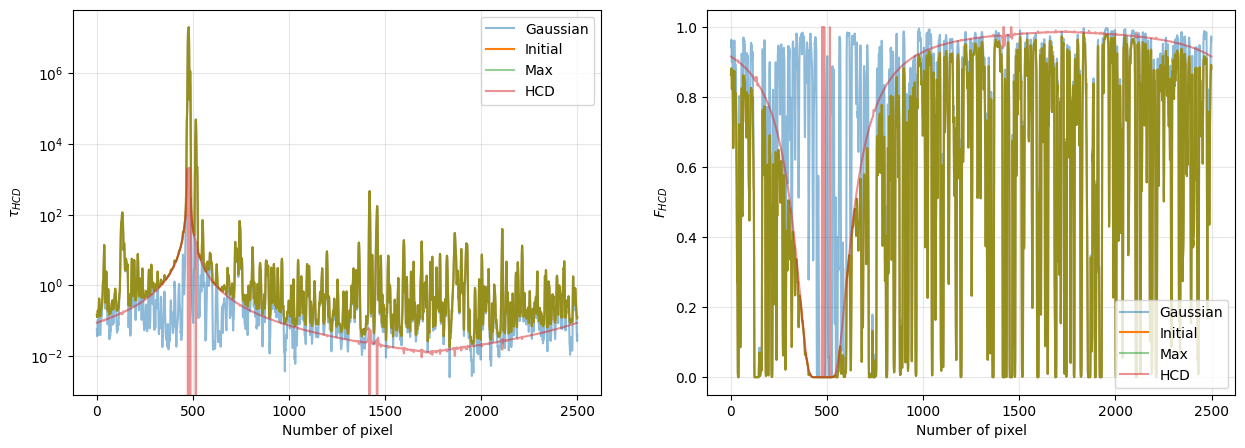

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(tau_off_mask[plt_skw, :], alpha=0.5, label='Gaussian')
plt.plot(tau_on_mask[plt_skw, :], label='Initial')
plt.plot(tau_max[plt_skw, :], alpha=0.5, label='Max')
plt.plot(tau_hcd_init[plt_skw, :], alpha=0.5, label='HCD')
plt.xlabel('Number of pixel')
plt.ylabel(r'$\tau_{HCD}$')
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.3);

plt.subplot(1, 2, 2)
plt.plot(np.exp(-tau_off_mask[plt_skw, :]), alpha=0.5, label='Gaussian')
plt.plot(np.exp(-tau_on_mask[plt_skw, :]), label='Initial')
plt.plot(np.exp(-tau_max[plt_skw, :]), alpha=0.5, label='Max')
plt.plot(np.exp(-tau_hcd_init[plt_skw, :]), alpha=0.5, label='HCD')
plt.xlabel('Number of pixel')
plt.ylabel(r'$F_{HCD}$')
plt.legend()
plt.grid(alpha=0.3);

We will now smooth it:

In [11]:
k_smooth = np.fft.rfftfreq(Np)*2*np.pi/Pw
smth_factor = 0.3
tau_modes = np.fft.rfft(tau_hcd_init)
tau_hcd = np.fft.irfft(tau_modes*(np.exp(-(smth_factor*k_smooth)**2)))

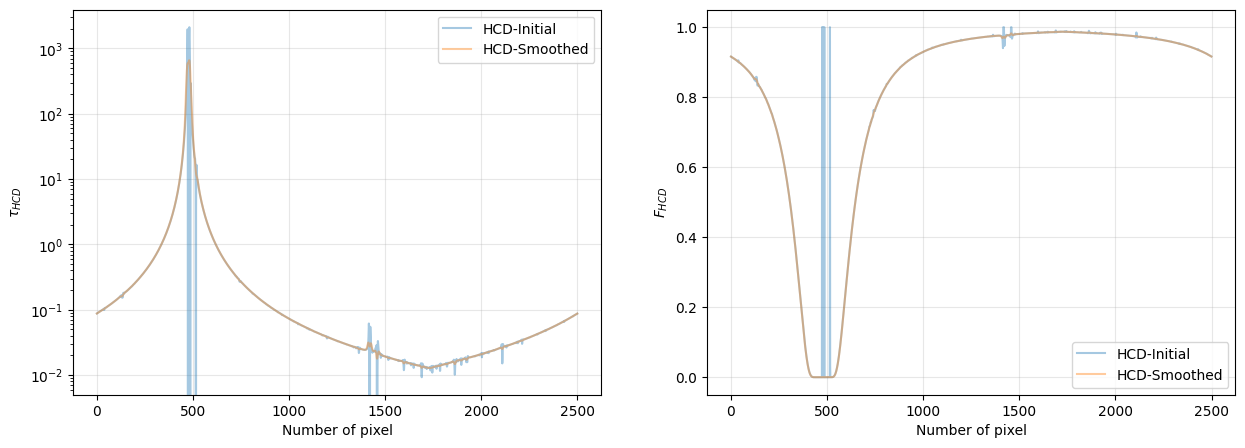

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(tau_hcd_init[plt_skw, :], alpha=0.4, label='HCD-Initial')
plt.plot(tau_hcd[plt_skw, :], alpha=0.4, label='HCD-Smoothed')
plt.xlabel('Number of pixel')
plt.ylabel(r'$\tau_{HCD}$')
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.3);

plt.subplot(1, 2, 2)
plt.plot(np.exp(-tau_hcd_init[plt_skw, :]), alpha=0.4, label='HCD-Initial')
plt.plot(np.exp(-tau_hcd[plt_skw, :]), alpha=0.4, label='HCD-Smoothed')
plt.xlabel('Number of pixel')
plt.ylabel(r'$F_{HCD}$')
plt.legend()
plt.grid(alpha=0.3);

Great! We can now calculate the different contributions

In [13]:
tau_lya = tau_off_mask
tau_tot = tau_hcd + tau_lya
del tau_hcd_init, tau_on_mask, tau_off_mask

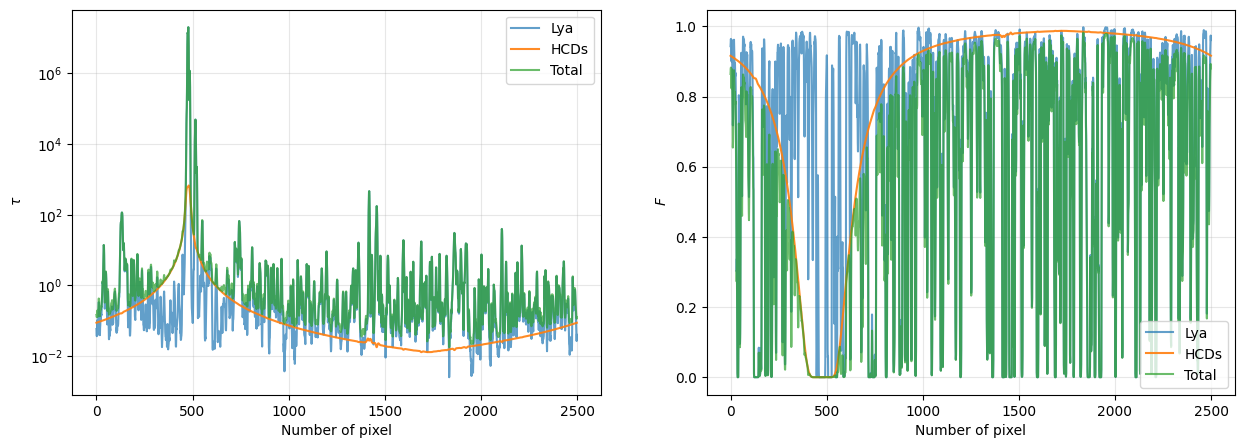

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(tau_lya[plt_skw, :], alpha=0.7, label='Lya')
plt.plot(tau_hcd[plt_skw, :], alpha=0.9, label='HCDs')
plt.plot(tau_tot[plt_skw, :], alpha=0.7, label='Total')
plt.xlabel('Number of pixel')
plt.ylabel(r' $\tau$')
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.3);

plt.subplot(1, 2, 2)
plt.plot(np.exp(-tau_lya[plt_skw, :]), alpha=0.7, label='Lya')
plt.plot(np.exp(-tau_hcd[plt_skw, :]), alpha=0.9, label='HCDs')
plt.plot(np.exp(-tau_tot[plt_skw, :]), alpha=0.7, label='Total')
plt.xlabel('Number of pixel')
plt.ylabel(r' $F$')
plt.legend()
plt.grid(alpha=0.3);

# Mean flux and deltas

In [16]:
F_hcd = np.exp(-tau_hcd)
F_lya = np.exp(-tau_lya)
F_tot = np.exp(-tau_tot)

del tau_hcd, tau_lya, tau_tot

In [17]:
Fmean_hcd = np.mean(F_hcd)
print('Mean HCD flux =', Fmean_hcd)
Fmean_lya = np.mean(F_lya)
print('Mean Lya flux =', Fmean_lya)
Fmean_tot = np.mean(F_tot)
print('Mean (total) flux =', Fmean_tot)
C = Fmean_tot/(Fmean_hcd*Fmean_lya) - 1
print('C value =', C)

Mean HCD flux = 0.9779275149014024
Mean Lya flux = 0.6305612536458872
Mean (total) flux = 0.6201026513028353
C value = 0.00561013489337836


In [18]:
delta_hcd = F_hcd/Fmean_hcd - 1
delta_lya = F_lya/Fmean_lya - 1
delta_tot = F_tot/Fmean_tot - 1

del F_hcd, F_lya, F_tot

# Saving

In [19]:
with h5py.File("deltas_%.2f" %smth_factor, "w") as f:
    f.attrs['logNHI_min'] = logNHi_min
    f.attrs['logNHI_max'] = logNHi_max
    f.attrs['Smoothing factor'] = smth_factor
    f.create_dataset('delta_hcd', data=delta_hcd)
    f.create_dataset('delta_lya', data=delta_lya)
    f.create_dataset('delta_tot', data=delta_tot)
    f.create_dataset('mean_flux_hcd', data=Fmean_hcd)
    f.create_dataset('mean_flux_lya', data=Fmean_lya)
    f.create_dataset('mean_flux_tot', data=Fmean_tot)
    f.create_dataset('C', data=C)

In [25]:
deltas = '/global/homes/l/lflores/old_hcd/Simulation/deltas_0.30'

with h5py.File(deltas, 'r') as f:
    print('Atributes:')
    for k in f.attrs.keys():
        print(f'{k} = {f.attrs[k]}')
    print('----------------') 
    print('Data:')
    print(f.keys())

Atributes:
Smoothing factor = 0.3
logNHI_max = 21.3
logNHI_min = 0
----------------
Data:
<KeysViewHDF5 ['C', 'delta_hcd', 'delta_lya', 'delta_tot', 'mean_flux_hcd', 'mean_flux_lya', 'mean_flux_tot']>
